# Imports


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

from pathlib import Path
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from model.llm import LLM
from model.tokenizer import Tokenizer, train_tokenizer

from helpers.dataset import NextTokenPredictionDataset
from helpers.trainer import train
from helpers.config import LLMConfig, TrainingConfig, get_device


print(f"pytorch version: {torch.__version__}")

pytorch version: 2.5.1+cu124


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /home/sysadm/Tuhin/LLM2_Updated/LLM2/data/aranyakanda_english.txt
  input_format: 
  model_prefix: /home/sysadm/Tuhin/LLM2_Updated/LLM2/data/aranyakanda_english
  model_type: BPE
  vocab_size: 6000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 1000000
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: <unk>
  bos_

# Set config


In [3]:

# llm_config and train_config are configuration objects used for configuring the language model (LLM) and the training process, respectively. 

llm_config = LLMConfig(
    # The size of the vocabulary used by the language model.
    vocab_size=6000,
    # The size of the context window, i.e., the number of tokens considered as context for predicting the next token.
    context_size=128,
    # The dimensionality of the token embeddings.
    dim_emb=256,
    # The number of layers in the transformer architecture of the language model.
    num_layers=64,
    # The number of attention heads in the multi-head self-attention mechanism.
    num_heads=32,
    # The dropout probability applied to the token embeddings.
    emb_dropout=0.0,
    # The dimensionality of the hidden layer in the feedforward network within the transformer layers.
    ffd_dim_hidden=4 * 256,
    # A boolean indicating whether bias is used in the feedforward network within the transformer layers.
    ffd_bias=False,
)

train_config = TrainingConfig(
    retrain_tokenizer=False,
    device=torch.device("cpu"),
    # The batch size used during training.
    batch_size=64,
    # The learning rate used for optimization during training.
    learning_rate=3e-4,
    weight_decay=1e-5,
    # The maximum number of training steps (or iterations) for which the training will run.
    max_steps=4000,
    # For example, if set to 1, logging will happen after each training step.
    log_frequency=1,
)

# Prepare tokenizer and dataset


In [4]:
input_file ="/home/sysadm/Tuhin/LLM2_Updated/LLM2/data/aranyakanda_english.txt"
output_file = Path(input_file).with_suffix(".model")

if not output_file.exists() or train_config.retrain_tokenizer:
    train_tokenizer(input_file, llm_config.vocab_size)

tokenizer = Tokenizer(str(output_file))

In [5]:
print(tokenizer.vocab_size)

6000


In [6]:
sentence = (
    "The invincible and selfpossessed Rama entered the great forest of Dandaka and saw there a multitude of hermitages of the ascetics."
)

ipt=tokenizer.sp.EncodeAsPieces(sentence)
print(ipt)
print(tokenizer.sp.DecodePieces(ipt))

# len(tokenizer.sp.EncodeAsIds(sentence))

['▁The', '▁invincible', '▁and', '▁self', 'possessed', '▁Rama', '▁entered', '▁the', '▁great', '▁forest', '▁of', '▁Dandaka', '▁and', '▁saw', '▁there', '▁a', '▁mult', 'itude', '▁of', '▁hermitages', '▁of', '▁the', '▁ascetics', '.']
The invincible and selfpossessed Rama entered the great forest of Dandaka and saw there a multitude of hermitages of the ascetics.


In [7]:
# This helper class allow to generate batches of inputs and targets where targets last element is the next token to predict
ds_train = NextTokenPredictionDataset(input_file, llm_config.context_size, tokenizer)
X, y = ds_train.get_batch(batch_size=1)
print(X,y)
# The last element of y seems to be the token to predict next.
print(X.shape, y.shape)

tensor([[ 765,   77,  418, 5934, 1766,   17,    8, 2124, 5934,   42,    8, 2159,
          793,   88,  222,  109, 3234, 3250,  290, 5412,  192,   77,   91, 5961,
         2470,  453,    8, 1401,  280,  319,   30,   30,    8, 1206, 4139, 5935,
          455, 5717,   47, 2264, 5934,  133,    5, 2498,   47, 2766, 5935,  439,
          232, 4865,  133, 2350,  425, 5934,    8, 1206, 4519,  280, 3739,   30,
         2049,   42, 4470,   91]], dtype=torch.int32) tensor([[  77,  418, 5934, 1766,   17,    8, 2124, 5934,   42,    8, 2159,  793,
           88,  222,  109, 3234, 3250,  290, 5412,  192,   77,   91, 5961, 2470,
          453,    8, 1401,  280,  319,   30,   30,    8, 1206, 4139, 5935,  455,
         5717,   47, 2264, 5934,  133,    5, 2498,   47, 2766, 5935,  439,  232,
         4865,  133, 2350,  425, 5934,    8, 1206, 4519,  280, 3739,   30, 2049,
           42, 4470,   91, 1233]])
torch.Size([1, 64]) torch.Size([1, 64])


# Define model


In [8]:
model = LLM(
    vocab_size=tokenizer.vocab_size,
    context_size=llm_config.context_size,
    dim_emb=llm_config.dim_emb,
    num_layers=llm_config.num_layers,
    attn_num_heads=llm_config.num_heads,
    emb_dropout=llm_config.emb_dropout,
    ffd_hidden_dim=llm_config.ffd_dim_hidden,
    ffd_bias=llm_config.ffd_bias,
)

params_size = sum(p.nelement() * p.element_size() for p in model.parameters())
buffer_size = sum(p.nelement() * p.element_size() for p in model.buffers())
size = (params_size + buffer_size) / 1024**2

print(f"total params: {sum(p.numel() for p in model.parameters()):,d}")
print(f"model size: {size:.3f}MB")

# print(model)

total params: 49,256,560
model size: 188.211MB


# Train model


In [9]:
loss_history = train(
    model,
    ds_train,
    train_config.device,
    batch_size=train_config.batch_size,
    lr=train_config.learning_rate,
    max_steps=train_config.max_steps,
    weight_decay=train_config.weight_decay,
    log_every=train_config.log_frequency,
)

Training on cpu.


KeyboardInterrupt: 

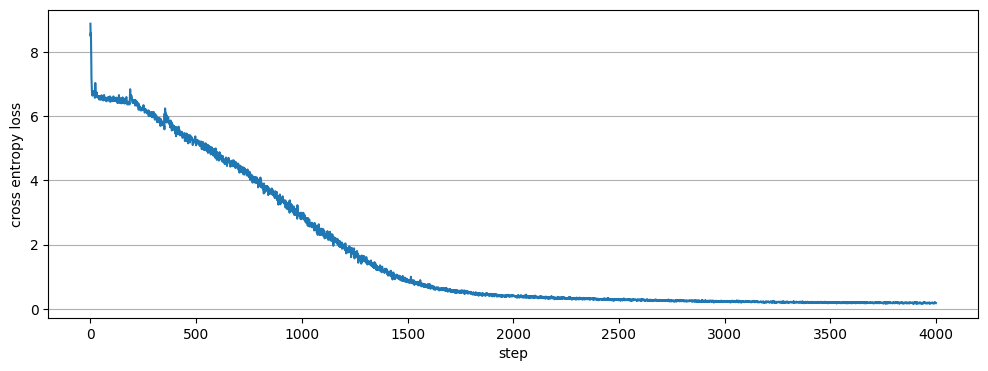

In [19]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(range(len(loss_history["train_loss"])), loss_history["train_loss"])
ax.set_xlabel("step")
ax.set_ylabel("cross entropy loss")
ax.grid(axis="y")

# Play around


In [20]:
prompt = torch.full((1, llm_config.context_size), tokenizer.pad_id, dtype=torch.int32).to(train_config.device)
out = model.generate(prompt, max_seq_len=30)
tokenizer.decode(out)

'due to his obligededed him near down disfigured. Like a demon army with her radiance, bent both the hands of Rama and Lakshmana cut eyes'

In [21]:
# generate from a prompt
prompt = (
    tokenizer.encode(
        "Kaikeyi is one of the three queens",
        beg_of_string=True,
        pad_seq=True,
        seq_len=llm_config.context_size,
    )
    .view(1, -1)
    .to(train_config.device)
)
out = model.generate(prompt, max_seq_len=90)
print("\n")
tokenizer.decode(out)

'Kaikeyi is one of the three queens of arms. If he Lanka on the words of her abductioned which he reached a sage mouth. The demon transformed him, a whizcloud filling the sky and the earth and produced the arrows of a sea. Then the Ravana fully in his guise of a kshatriya hold of great speed. With his sylvan ny speed itsulressed with dark twangining with Rama, pray burned with. They then emer aloud by misfortune.इत्यार्षे श्रीमद्रामायणे वाल्मीकीय'

In [22]:
# generate from a prompt
prompt = (
    tokenizer.encode(
        "Kaikeyi is one of the three queens",
        beg_of_string=True,
        pad_seq=True,
        seq_len=llm_config.context_size,
    )
    .view(1, -1)
    .to(train_config.device)
)
out = model.generate(prompt, max_seq_len=90)
print("\n")
tokenizer.decode(out)

'Kaikeyi is one of the three queens of her angry. These bow at the time demon, be on his shoulders and golden body started : The demon Maricha, his arms, put down with blood, he gave down the ground and, sharp shoulders and smiling at bewilderedught and shaking the chariot and said : Thereafter Jatayu thus seated, engrossed and feet with both his brother and hit the armour of Ravana who came forward to crush the army of Khara and met Lakshmana for his immense body and also the'

In [28]:
# generate from a prompt
prompt = (
    tokenizer.encode(
        "Who is Rama?",
        beg_of_string=True,
        pad_seq=True,
        seq_len=llm_config.context_size,
    )
    .view(1, -1)
    .to(train_config.device)
)
out = model.generate(prompt, max_seq_len=90)
print("\n")
tokenizer.decode(out)

"Who is Rama?: Where could I could delightful sylvan eye at your arms. (Ad demon Ravana) like whom I wandered down like fire which I have come here. I could not think her tears these deer without Sita who deserting his death out of love without fear in the wellbeing of his own abduction. This lord of Lanka along with Sita, princess of Mithila, the demon king of demons, commanded by my prowess, Rama's beloved captivcid he"